<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/ecg_classification_rnn_gru_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main'

In [20]:
!pip install -qqqq mlflow torchmetrics tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [21]:
import mlflow
import pandas as pd
import numpy as np

In [23]:
!pwd

/content


In [22]:
# Define paths
df_path = "src/data/df_memmap.csv"
train_df_path = "src/data/train_df.csv"
val_df_path = "src/data/val_df.csv"

df = pd.read_csv(df_path)
train_df = pd.read_csv(train_df_path)
val_df = pd.read_csv(val_df_path)

FileNotFoundError: [Errno 2] No such file or directory: 'src/data/df_memmap.csv'

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Utility Functions

In [ ]:
# Function to plot loss, accuracy and best epoch

def learning_curves_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)

    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')

    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Load & Explore Data

In [ ]:
# Load dataset
train_data = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv')
test_data = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv')

In [ ]:
print(f"Number of samples in train data: {train_data.shape[0]}")
print(f"Number of samples in test data: {test_data.shape[0]}")

Number of samples in train data: 87553
Number of samples in test data: 21891


In [ ]:
# Explore the dataset
train_data.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f"Missing values in train data: {train_data.isna().sum().sum()}")
print(f"Missing values in test data: {test_data.isna().sum().sum()}")

Missing values in train data: 0
Missing values in test data: 0


In [ ]:
print(f"Duplicated values in train data: {train_data.duplicated().sum()}")
print(f"Duplicated values in test data: {test_data.duplicated().sum()}")

Duplicated values in train data: 0
Duplicated values in test data: 0


In [ ]:
print(train_data.iloc[:, -1].value_counts())  # Check class distribution in train data

0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [ ]:
print(test_data.iloc[:, -1].value_counts())  # Check class distribution in test data

0.000000000000000000e+00.65
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [ ]:
test_classes = test_data.iloc[:, -1].unique()
train_classes = train_data.iloc[:, -1].unique()

In [ ]:
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

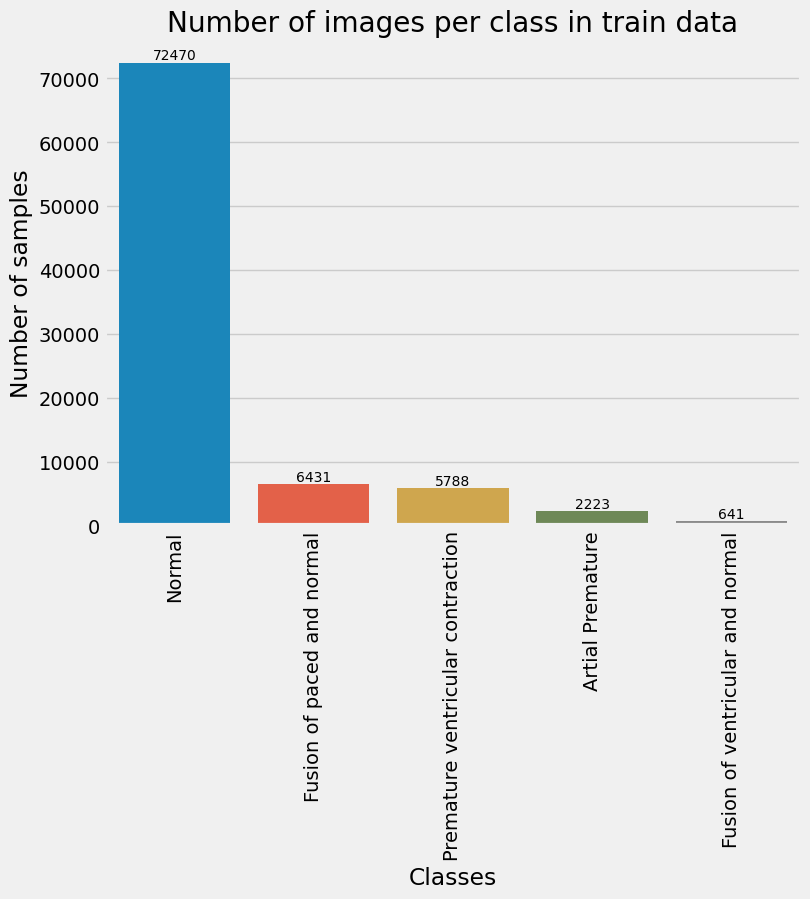

In [ ]:
train_counts = train_data.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=train_counts.index, y=train_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{train_counts[i]}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10)

plt.title('Number of images per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

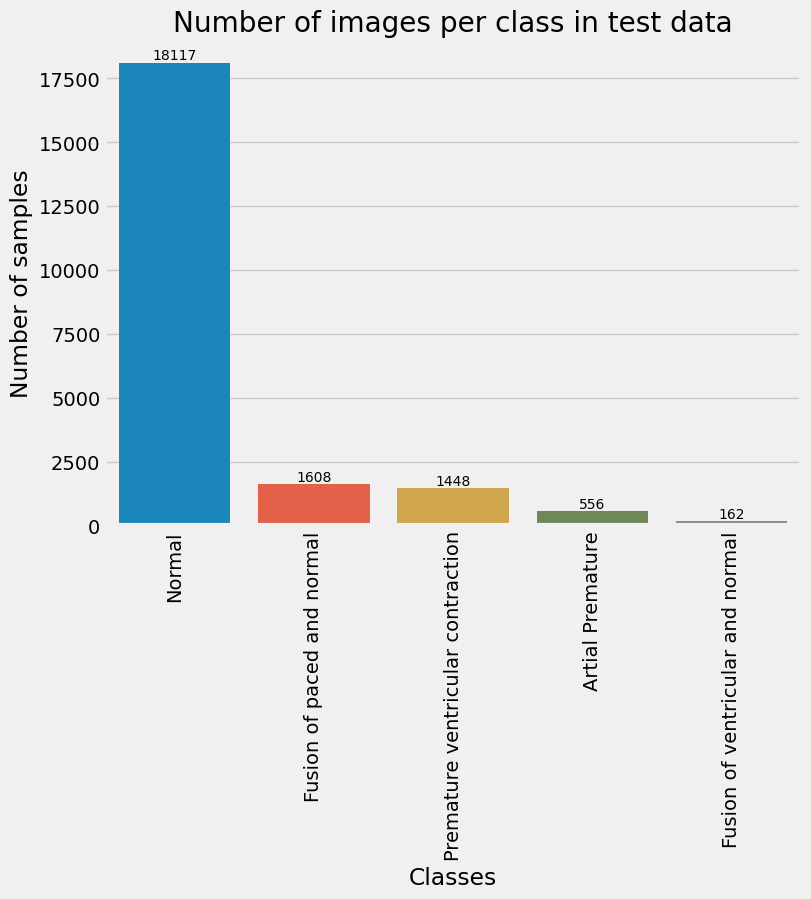

In [ ]:
test_counts = test_data.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=test_counts.index, y=test_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{test_counts[i]}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10)

plt.title('Number of images per class in test data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

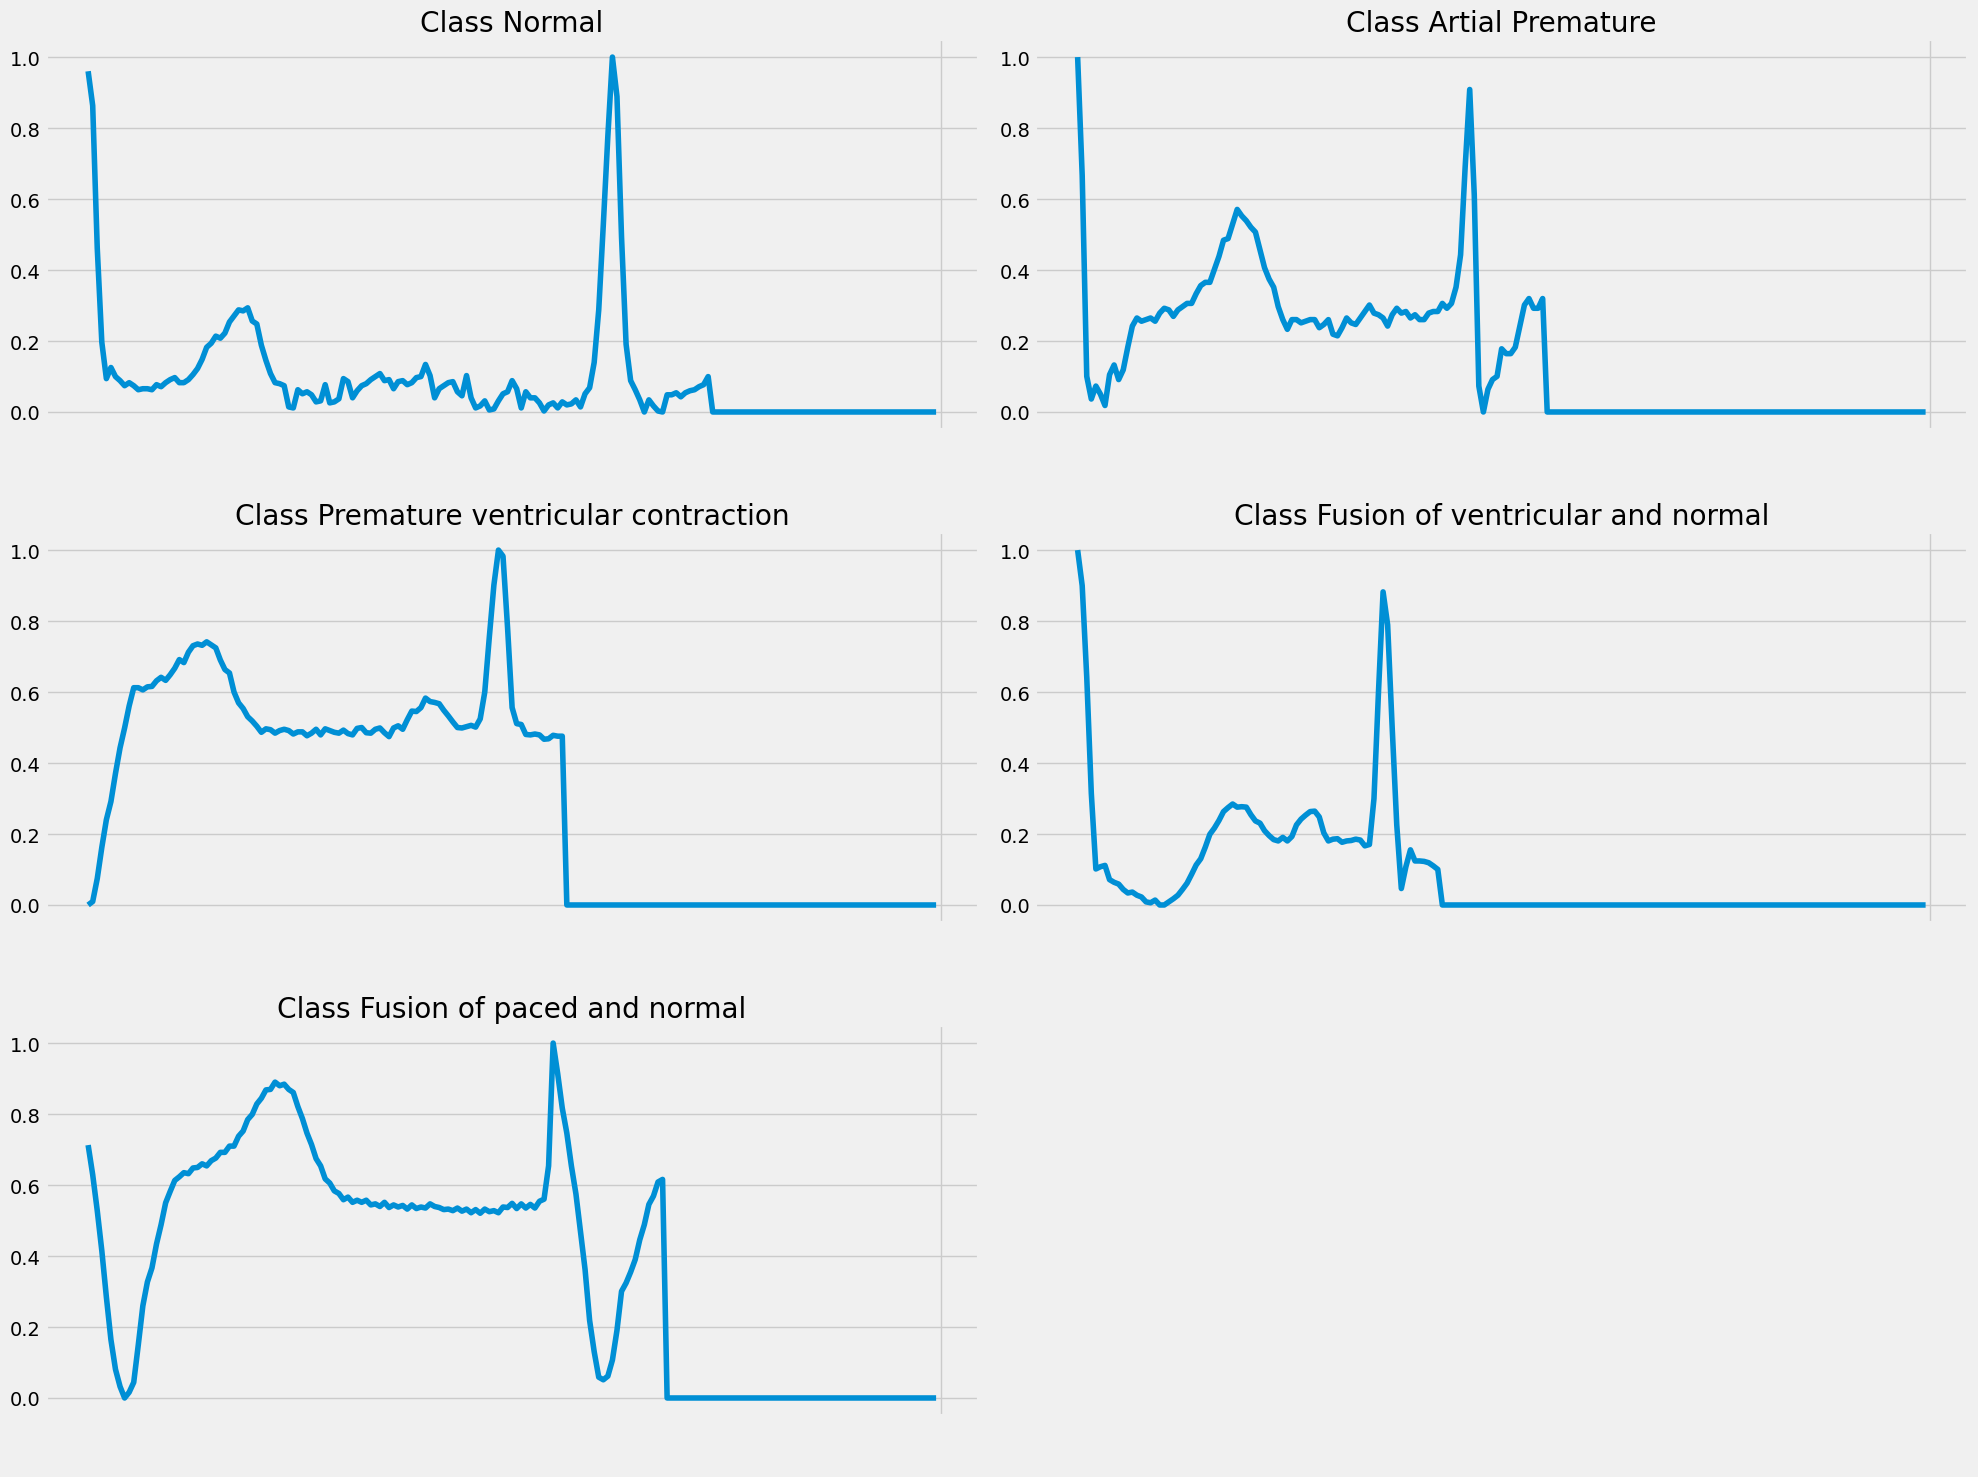

In [ ]:
# Plot each class
train_classes = train_data.iloc[:, -1].unique()

plt.figure(figsize=(20, 15))

for i, cls in enumerate(train_classes):
    plt.subplot(3, 2, i + 1)
    plt.plot(train_data[train_data.iloc[:, -1] == cls].iloc[0, :-1])  # Exclude the label column
    plt.title(f'{list(labels.values())[i]}')
    plt.xlabel(" ")
    plt.xticks(ticks=" ",labels =" ",rotation=45)

plt.tight_layout()
plt.show()

# Data Preprocessing

In [ ]:
# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # Exclude label
y_train = train_data.iloc[:, -1].values   # Labels

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Scailing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the number of samples for the validation set based on the test data size
n_test_samples = X_test_scaled.shape[0]

# Split the training data into new training and validation sets
X_val, X_test_new, y_val, y_test_new = train_test_split(X_test_scaled, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Reshape the data for RNN/LSTM/GRU (samples, timesteps, features)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], 1))


print(f"New Training set size: {X_train_scaled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test_new.shape[0]}")

New Training set size: 87553
Validation set size: 10945
Test set size: 10946


# RNN

In [ ]:
def build_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
rnn_model = build_rnn_model()

In [ ]:
rnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              verbose=1,
                              patience=2,
                              min_lr=1e-6)

model_checkpoint = ModelCheckpoint('model.keras',
                                   monitor='val_loss',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
rnn_history = rnn_model.fit(X_train_scaled, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= callbacks)

Epoch 1/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.8152 - loss: 0.7183 - val_accuracy: 0.8276 - val_loss: 0.6678 - learning_rate: 0.0010
Epoch 2/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 73s 26ms/step - accuracy: 0.8250 - loss: 0.6756 - val_accuracy: 0.8276 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 3/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accuracy: 0.8291 - loss: 0.6589 - val_accuracy: 0.8276 - val_loss: 0.6599 - learning_rate: 0.0010
Epoch 4/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accuracy: 0.8273 - loss: 0.6655 - val_accuracy: 0.8276 - val_loss: 0.6586 - learning_rate: 0.0010
Epoch 5/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accuracy: 0.8274 - loss: 0.6637 - val_accuracy: 0.8276 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 6/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accuracy: 0.8289 - loss: 0.6328 - val_accuracy: 0.8276 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 7/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accura

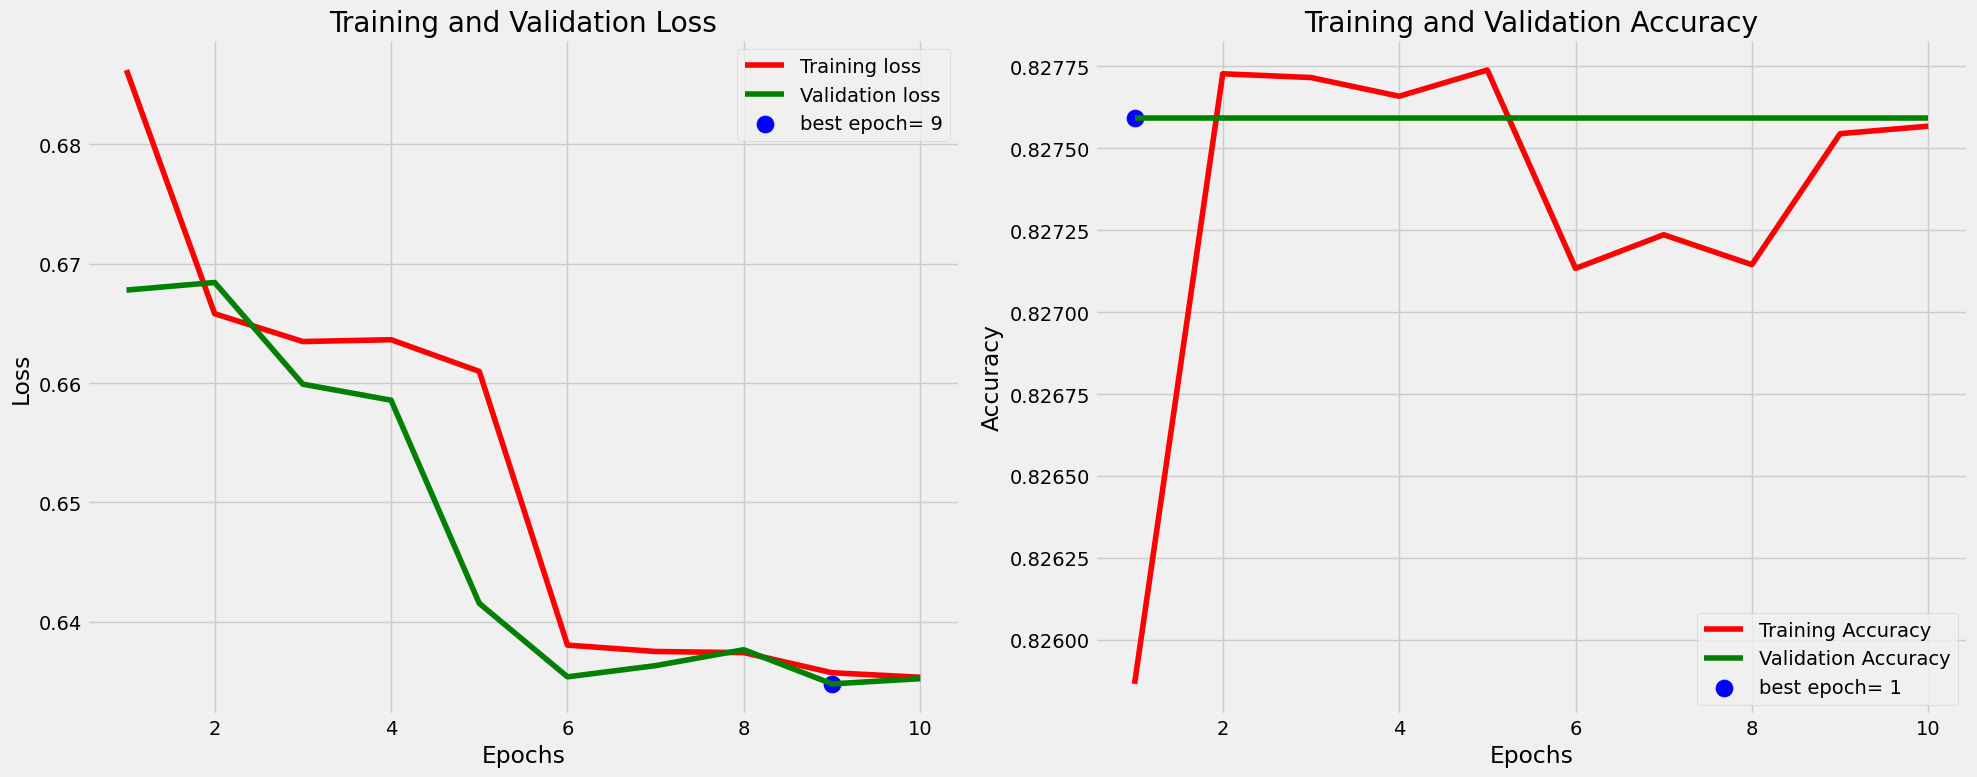

In [ ]:
learning_curves_plot(rnn_history, start_epoch=0)

In [ ]:
# Predict on the test set
y_test_pred_rnn = rnn_model.predict(X_test_new).argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
# Evaluate RNN Model on Test Data
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"RNN Test Loss: {rnn_test_loss:.4f}")
print(f"RNN Test Accuracy: {rnn_test_acc:.4f}")

RNN Test Loss: 0.6309
RNN Test Accuracy: 0.8276


In [ ]:
# Classification report for RNN
print("RNN Classification Report:")
print(classification_report(y_test_new, y_test_pred_rnn))

RNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      9059
         1.0       0.00      0.00      0.00       278
         2.0       0.00      0.00      0.00       724
         3.0       0.00      0.00      0.00        81
         4.0       0.00      0.00      0.00       804

    accuracy                           0.83     10946
   macro avg       0.17      0.20      0.18     10946
weighted avg       0.68      0.83      0.75     10946



In [ ]:
class_names = [labels[i] for i in range(len(labels))]

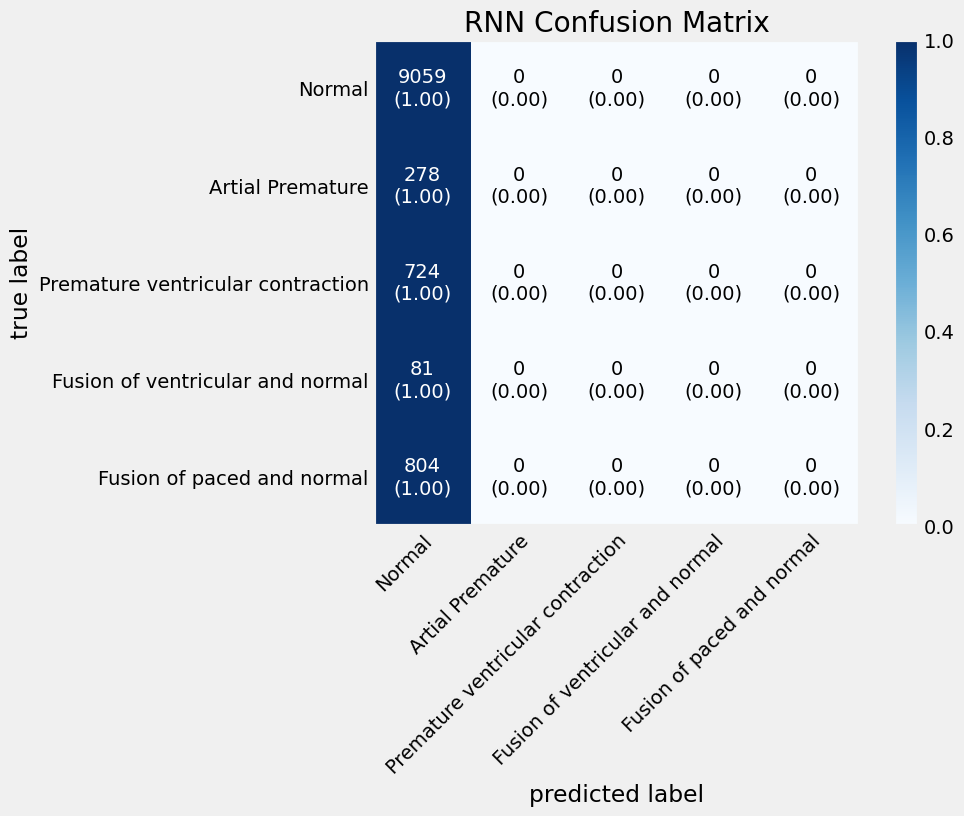

In [ ]:
# Confusion Matrix for RNN
conf_matrix_rnn = confusion_matrix(y_test_new, y_test_pred_rnn)

plot_confusion_matrix(conf_matrix_rnn,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('RNN Confusion Matrix')
plt.show()

# GRU

In [ ]:
def build_gru_model():
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
gru_model = build_gru_model()

In [ ]:
gru_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
gru_history = gru_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= callbacks)

Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.8453 - loss: 0.5887 - val_accuracy: 0.9325 - val_loss: 0.2392 - learning_rate: 0.0010
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.9428 - loss: 0.2139 - val_accuracy: 0.9589 - val_loss: 0.1622 - learning_rate: 0.0010
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.9594 - loss: 0.1503 - val_accuracy: 0.9650 - val_loss: 0.1326 - learning_rate: 0.0010
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.9660 - loss: 0.1258 - val_accuracy: 0.9698 - val_loss: 0.1098 - learning_rate: 0.0010
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.9717 - loss: 0.1062 - val_accuracy: 0.9720 - val_loss: 0.1037 - learning_rate: 0.0010
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.9736 - loss: 0.0969 - val_accuracy: 0.9721 - val_loss: 0.0972 - learning_rate: 0.0010
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accura

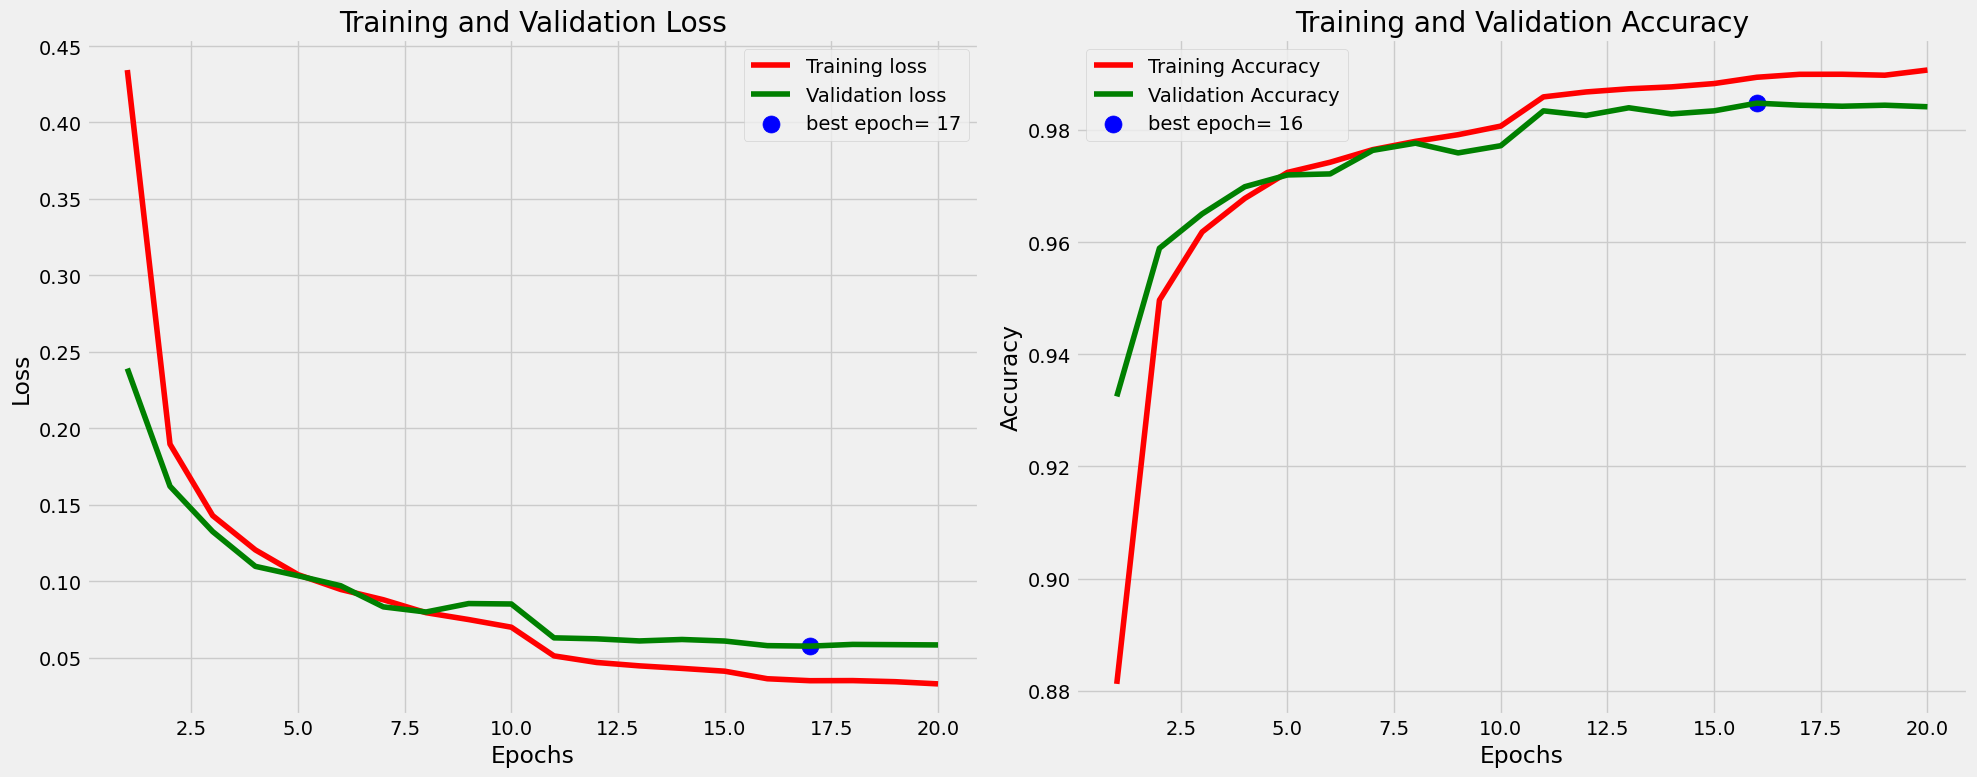

In [ ]:
learning_curves_plot(gru_history, start_epoch=0)

In [ ]:
y_test_pred_gru = gru_model.predict(X_test_new).argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
# Evaluate GRU Model on Test Data
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"GRU Test Loss: {gru_test_loss:.4f}")
print(f"GRU Test Accuracy: {gru_test_acc:.4f}")

GRU Test Loss: 0.0568
GRU Test Accuracy: 0.9860


In [ ]:
# GRU classification report
print("GRU Classification Report:")
print(classification_report(y_test_new, y_test_pred_gru))

GRU Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9059
         1.0       0.93      0.77      0.84       278
         2.0       0.96      0.96      0.96       724
         3.0       0.82      0.80      0.81        81
         4.0       1.00      0.99      0.99       804

    accuracy                           0.99     10946
   macro avg       0.94      0.90      0.92     10946
weighted avg       0.99      0.99      0.99     10946



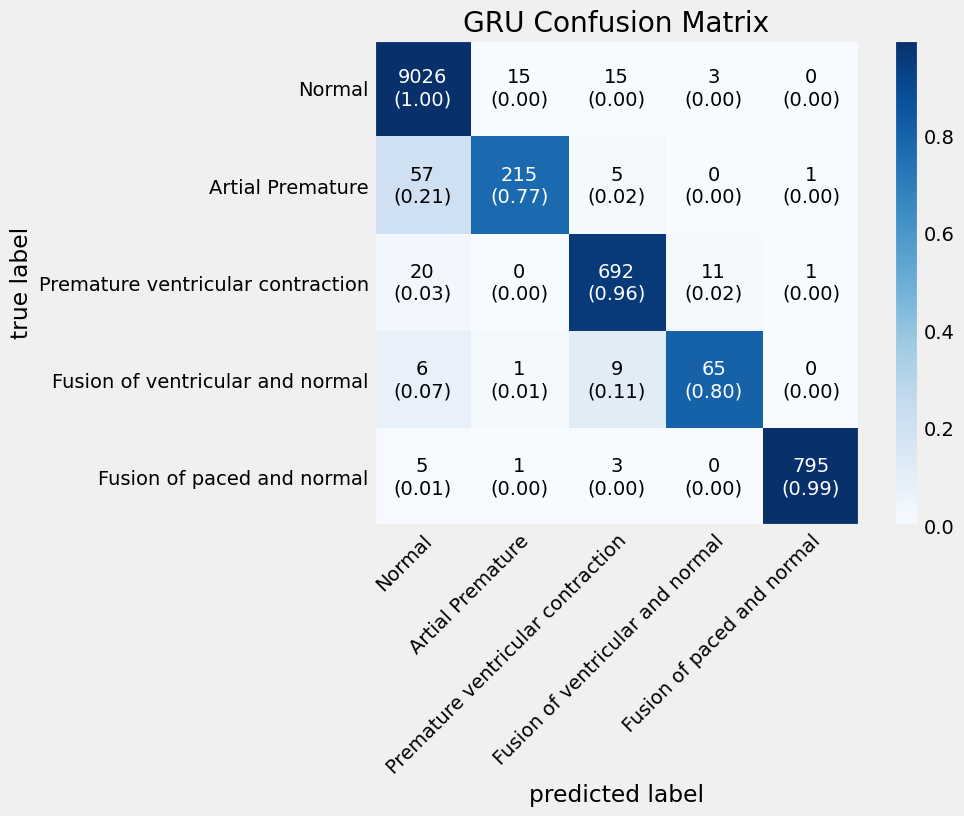

In [ ]:
# Confusion matrix for GRU
conf_matrix_gru = confusion_matrix(y_test_new, y_test_pred_gru)

plot_confusion_matrix(conf_matrix_gru,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('GRU Confusion Matrix')
plt.show()

# LSTM

In [ ]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
lstm_model = build_lstm_model()

In [ ]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
lstm_history = lstm_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= [reduce_lr, model_checkpoint])

Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8238 - loss: 0.6573 - val_accuracy: 0.8288 - val_loss: 0.6348 - learning_rate: 0.0010
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.8366 - loss: 0.5946 - val_accuracy: 0.8976 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9031 - loss: 0.3563 - val_accuracy: 0.9183 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9205 - loss: 0.2834 - val_accuracy: 0.9340 - val_loss: 0.2234 - learning_rate: 0.0010
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9339 - loss: 0.2336 - val_accuracy: 0.9314 - val_loss: 0.2477 - learning_rate: 0.0010
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9389 - loss: 0.2220 - val_accuracy: 0.9519 - val_loss: 0.1741 - learning_rate: 0.0010
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accura

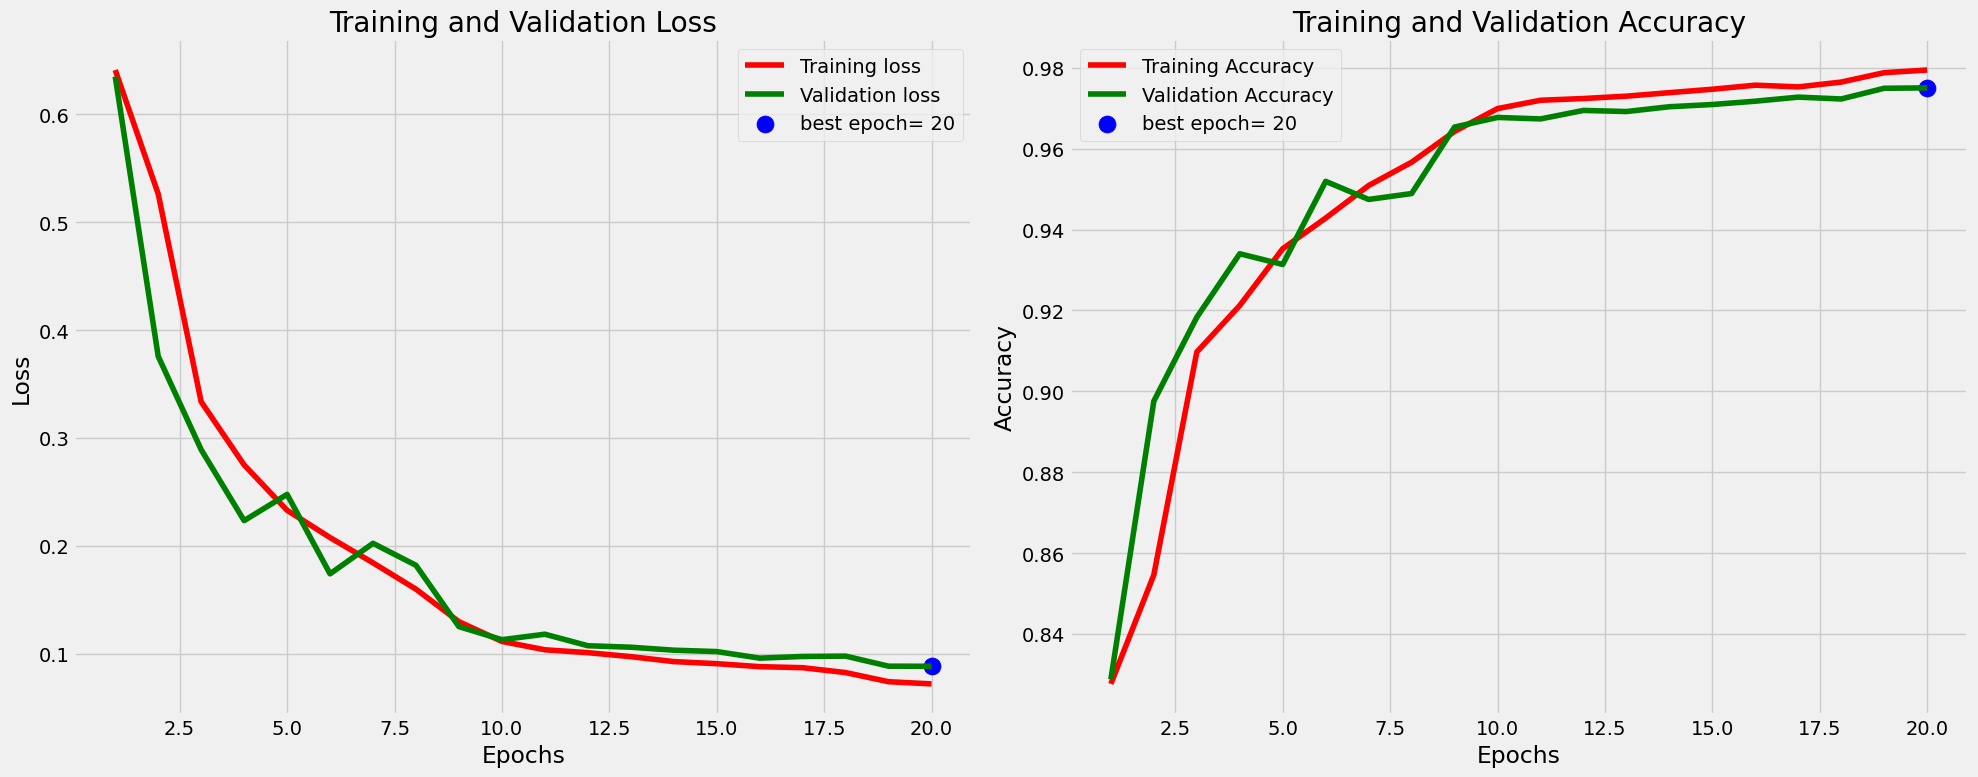

In [ ]:
learning_curves_plot(lstm_history, start_epoch=0)

In [ ]:
y_test_pred_lstm = lstm_model.predict(X_test_new).argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
# Evaluate LSTM Model on Test Data
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

LSTM Test Loss: 0.0848
LSTM Test Accuracy: 0.9776


In [ ]:
# LSTM classification report
print("LSTM Classification Report:")
print(classification_report(y_test_new, y_test_pred_lstm))

LSTM Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9059
         1.0       0.90      0.63      0.74       278
         2.0       0.94      0.92      0.93       724
         3.0       0.82      0.74      0.78        81
         4.0       0.99      0.97      0.98       804

    accuracy                           0.98     10946
   macro avg       0.93      0.85      0.88     10946
weighted avg       0.98      0.98      0.98     10946



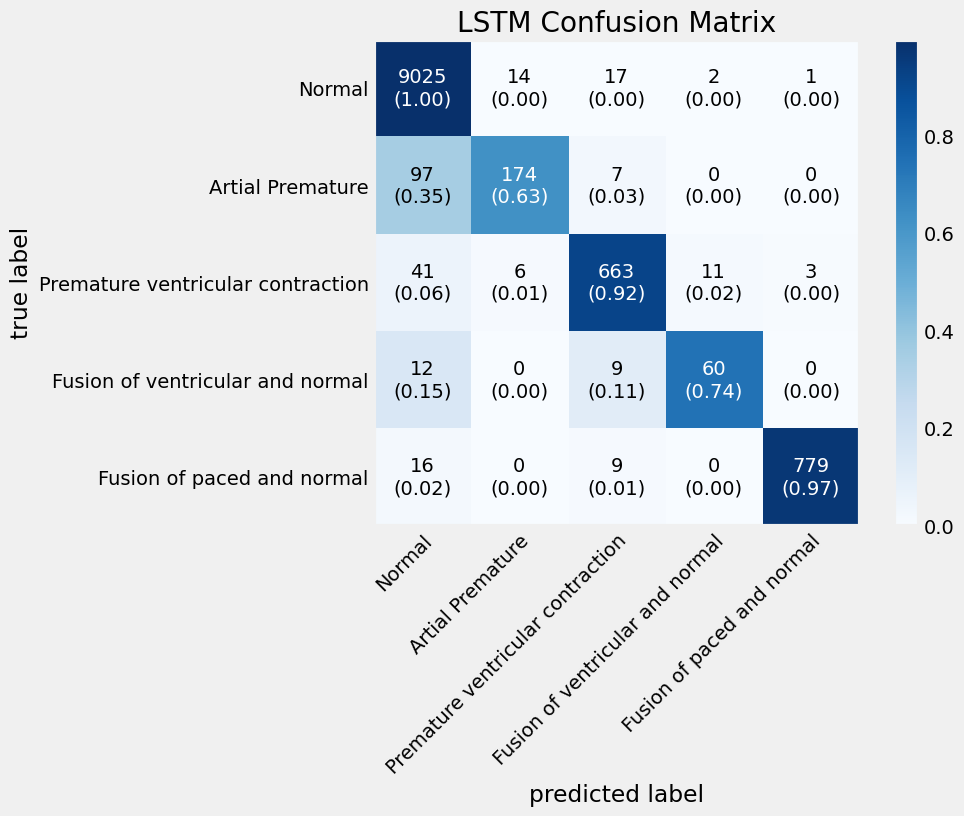

In [ ]:
# Confusion matrix for LSTM
conf_matrix_lstm = confusion_matrix(y_test_new, y_test_pred_lstm)

plot_confusion_matrix(conf_matrix_lstm,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('LSTM Confusion Matrix')
plt.show()

# Thank you